In [1]:
import numpy as np
import pandas as pd

In [2]:
import operator

from copy import copy

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
df = pd.read_csv("../data/train.txt", sep='\t', header=None, names=["users", "items", "rank"])
df.head()

,users,items,rank
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [6]:
df["rank"].unique()

array([5, 3, 4, 1, 2])

In [7]:
n_users = df["users"].max()
n_items = df["items"].max()

In [8]:
df[["users", "items"]] -= 1
df.head()

,users,items,rank
0,0,0,5
1,0,1,3
2,0,2,4
3,0,3,3
4,0,4,3


In [9]:
def score(matrix, values):
    y_pred = [matrix[user, item] for user, item, rank in values]
    y_true = map(operator.itemgetter(2), values)
    return mean_squared_error(y_true, y_pred)

In [10]:
def iter_step(weights, bias, df_grouped, C):
    weights_, bias_ = copy(weights), copy(bias)
    
    for user, group in df_grouped["users"]:
        index = group["items"].values
        
        Q = weights_["items"][index]
        Q = np.hstack((np.ones(shape=(len(index), 1), dtype=float), Q))
        r = group["rank"].values - bias_["items"][index]
        
        A = np.dot(Q.T, Q) + C * np.eye(Q.shape[1])
        b = np.dot(Q.T, r)
        
        solution = np.linalg.solve(A, b)
        weights_["users"][user], bias_["users"][user] = solution[1:], solution[0] 
    
    for item, group in df_grouped["items"]:
        index = group["users"].values
        
        P = weights_["users"][index]
        P = np.hstack((np.ones(shape=(len(index), 1), dtype=float), P))
        r = group["rank"].values - bias_["users"][index]
        
        A = np.dot(P.T, P) + C * np.eye(P.shape[1])
        b = np.dot(P.T, r)
        
        solution = np.linalg.solve(A, b)
        weights_["items"][item], bias_["items"][item] = solution[1:], solution[0]
        
    return weights_, bias_

In [11]:
index = np.random.permutation(df.shape[0])
alpha = int(0.8 * len(index))

df_train, df_valid = df.iloc[index[:alpha]], df.iloc[index[alpha:]]
    
df_grouped = {cat : df_train.groupby(by=cat) for cat in ["users", "items"]}

In [12]:
C = 5.0
n_features = 4

In [13]:
weights = dict()
weights["users"] = np.random.normal(loc=0.0, scale=0.01, size=(n_users, n_features))
weights["items"] = np.random.normal(loc=0.0, scale=0.01, size=(n_items, n_features))

bias = dict()
bias["users"] = np.random.normal(loc=0.0, scale=0.01, size=(n_users, ))
bias["items"] = np.random.normal(loc=0.0, scale=0.01, size=(n_items, ))
    
scores = []
    
n_iters = 100

for i in range(n_iters):
    weigths, bias = iter_step(weights, bias, df_grouped, C)
            
    matrix = bias["users"].reshape(-1, 1) + bias["items"].reshape(1, -1) \
            + np.dot(weights["users"], weights["items"].T)
    scores.append(
        (score(matrix, df_train.values),
         score(matrix, df_valid.values))
    )
        
    print "\r{} of {} iters passed...".format(i + 1, n_iters),

100 of 100 iters passed...


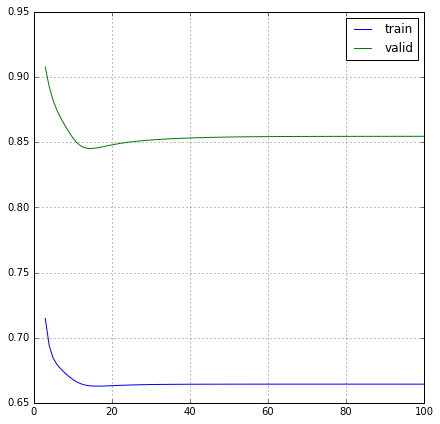

In [14]:
offset = 2

plt.figure(figsize=(7, 7))
plt.plot(range(offset+1, len(scores)+1), map(operator.itemgetter(0), scores)[offset:], label="train")
plt.plot(range(offset+1, len(scores)+1), map(operator.itemgetter(1), scores)[offset:], label="valid")
plt.legend()
plt.grid()

In [15]:
np.argsort(map(operator.itemgetter(1), scores))

array([14, 13, 15, 12, 16, 17, 11, 18, 19, 20, 21, 22, 10, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,  9,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
       94, 95, 96, 97, 98, 99,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [16]:
np.min(map(operator.itemgetter(1), scores))

0.84533271925192455